In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import os
import pickle
import gpflow

import tensorflow as tf
from sklearn.metrics import r2_score

2025-03-18 16:32:38.385794: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 16:32:38.408663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742337158.434754   42547 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742337158.444037   42547 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 16:32:38.474376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [47]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='06:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42105 instead
  warnings.warn(


In [53]:
client.cluster

PBSCluster(6fe174dc, 'tcp://128.117.208.103:39155', workers=25, threads=25, memory=465.75 GiB)

In [3]:
def build_kernel_dict(num_params):
    kernel_noise = gpflow.kernels.White(variance=1e-3)
    kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=10, lengthscales = np.tile(10,num_params))
    kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,num_params))
    kernel_bias = gpflow.kernels.Bias(active_dims = range(num_params))
    kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=[1.]*num_params)
    kernel_poly = gpflow.kernels.Polynomial(active_dims = range(num_params),variance=[1.]*num_params)
    kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
    
    kernel_dict = {
        0:kernel_RBF + kernel_linear + kernel_noise,
        1:kernel_RBF + kernel_linear + kernel_noise + kernel_bias,
        2:kernel_poly + kernel_linear + kernel_noise,
        3:kernel_RBF + kernel_linear + kernel_noise + kernel_bias + kernel_poly,
        4:kernel_matern32,
        5:kernel_matern32*kernel_linear+kernel_noise,
        6:kernel_linear*kernel_RBF+kernel_matern32 + kernel_noise
    }
    return kernel_dict

In [13]:
def build_X(biome,u_params,pft_params,biome_pfts):

    u_lhc = params_lhc[u_params]
    u_wave1 = params_wave1.sel(param=u_params,pft=1)
    uX = np.concatenate((u_lhc.values,u_wave1.values))
    
    X = pd.DataFrame(uX,columns=u_params)
    for pft in biome_pfts[biome]:
        p_lhc = params_lhc[pft_params]
        p_wave1 = params_wave1.sel(pft=pft,param=pft_params)
    
        pX = np.concatenate((p_lhc.values,p_wave1.values))
        param_names = [f"{param}_{pft}" for param in pft_params]
        X = pd.concat([X, pd.DataFrame(pX, columns=param_names)], axis=1)
        
    return X

In [4]:
#def pxb_to_biome(ds,biome,y1,y2):
#    f='/glade/u/home/linnia/ctsm6_ppe/utils/lapxb_sg_sudoku_ctsm53017.nc'
#    lapxb=xr.open_dataset(f).lapxb_sg
#    la_pxb = lapxb.sel(year=slice(y1,y2))
#    pxb = la_pxb.pxb.values

#    ix = [i for i, item in enumerate(pxb) if item.endswith('_'+str(biome))]
#    pxb_lai = ds.isel(pxb = ix).sel(year=slice(y1,y2))
#    pxb_la = la_pxb.isel(pxb=ix).sum(dim='pft')
#    biome_lai = (1/pxb_la.sum(dim='pxb'))*((pxb_la*pxb_lai).sum(dim='pxb'))

#    return biome_lai.mean(dim='year')

In [4]:
biome_pfts = {
    "Boreal shrubland": [12],
    "Tundra": [11, 12],
    "Boreal forest": [2,11,12],
    "Siberian larch" : [3,11,12],
    
    "Tropical rainforest" : [4],
    "Tropical savanna": [4,14],
    "Subtropical savanna" : [4,6,14],

    "Grasslands" : [13,14],
    "Shrubland" :  [10,13,14],
    
    "Mixed deciduous temperate forest" : [1,7,13,14],

    "Conifer forest" : [1,2,13,14],

    "Broadleaf deciduous boreal trees" : [2,8,12,13],

    "Broadleaf evergreen temperate tree" :[5,13,14],

}

In [5]:
obs_biome = xr.open_dataset('wave2_obsStatistics_sudokuBiomes.nc')

In [6]:
file='../../biomes/sudoku_biomes.nc'
biomes=xr.open_dataset(file)
biome_names = biomes.biome_names.values

In [15]:
pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
               'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

### load LHC

In [7]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

In [9]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)

In [10]:
# drop crashers
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
ix = np.where(ds_lhc.crashed==1)[0]
params_lhc = params.drop(ix-1)

lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')) #.mean(dim='year').compute()
gpp_lhc = (60*60*24)*lhc_pxb.GPP_biome_amean.sel(year=slice('2001','2015')) #.mean(dim='year').compute()
#et_lhc = lhc_grid.EFLX_LH_TOT_gridded_amean.sel(year=slice('2001','2020')).mean(dim='year').compute()
biomass_lhc = (1/1000)*lhc_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')) #.mean(dim='year').compute()

### load Wave 1 

In [11]:
######################################################
# load wave 1 data
filename = '../wave1/params/wave1_psets_021725.nc'
w1_params = xr.open_dataset(filename)

dir='/glade/work/linnia/CLM6-PPE/ctsm6_wave1/postp/'
ds = xr.open_dataset(dir+'ctsm6wave1_pxbmean_sudoku_1985-2023.nc')

# drop crashers
ds_wave1 = ds.where(ds['crashed'] != 1, drop=True)

ix = np.where(ds.crashed==1)[0]
params_wave1 = w1_params['values'].drop_sel(ens=ix)
params_wave1 = params_wave1.transpose("ens", "param", "pft")
params_wave1 = params_wave1.sel(param=params_lhc.columns)

lai_wave1 = ds_wave1.TLAI_biome_amax.sel(year=slice(2001,2020))#.mean(dim='year').compute()
gpp_wave1 = (60*60*24)*ds_wave1.GPP_biome_amean.sel(year=slice(2001,2015)) #.mean(dim='year').compute()
#et_wave1 = ds_wave1.EFLX_LH_TOT_gridded_amean.sel(year=slice(2001,2020)).mean(dim='year').compute()
biomass_wave1 = (1/1000)*ds_wave1.TOTVEGC_biome_amean.sel(year=slice(2000,2019)) #.mean(dim='year').compute()

### Train LAI emulators

In [41]:
ntest = 200
X = build_X('Tundra',u_params,pft_params,biome_pfts)
ix_test = np.random.choice(np.arange(len(X)), size=ntest, replace=False)
ix_train = np.where(~np.isin(np.arange(len(X)), ix_test))[0]


In [35]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(len(biome_ix))*np.NaN
stdev = np.empty(len(biome_ix))*np.NaN

1 Tropical rainforest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Tropical rainforest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Tropical rainforest/assets


2 Tropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Tropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Tropical savanna/assets


3 Subtropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Subtropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Subtropical savanna/assets


4 Broadleaf evergreen temperate tree
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Broadleaf evergreen temperate tree/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Broadleaf evergreen temperate tree/assets


5 Grasslands
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Grasslands/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Grasslands/assets


6 Shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Shrubland/assets


7 Mixed deciduous temperate forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Mixed deciduous temperate forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Mixed deciduous temperate forest/assets


8 Conifer forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Conifer forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Conifer forest/assets


9 Siberian larch
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Siberian larch/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Siberian larch/assets


10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Boreal forest/assets


11 Broadleaf deciduous boreal trees
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Broadleaf deciduous boreal trees/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Broadleaf deciduous boreal trees/assets


12 Boreal shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Boreal shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Boreal shrubland/assets


13 Tundra
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai/Tundra/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai/Tundra/assets


IndexError: index 13 is out of bounds for axis 0 with size 13

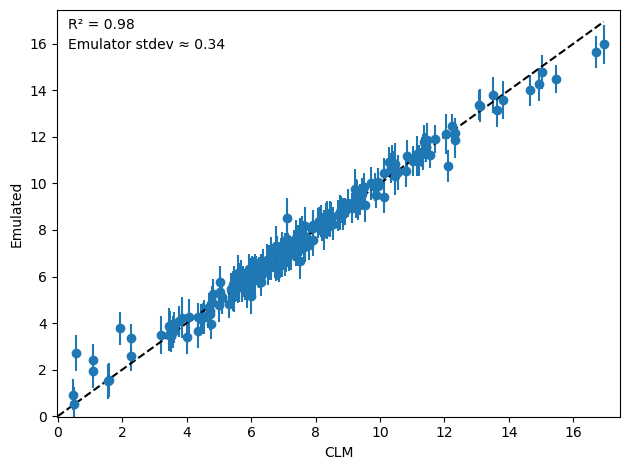

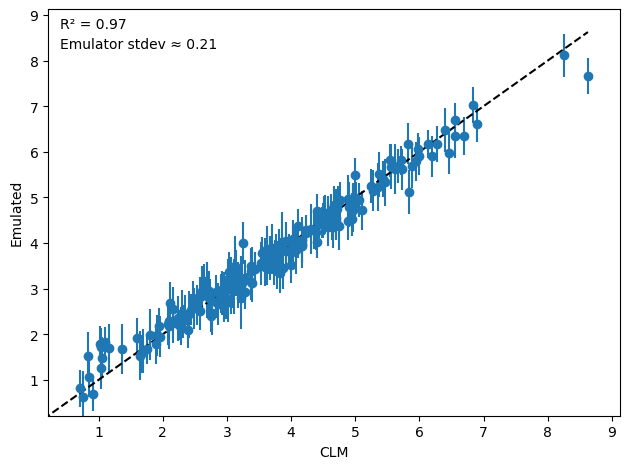

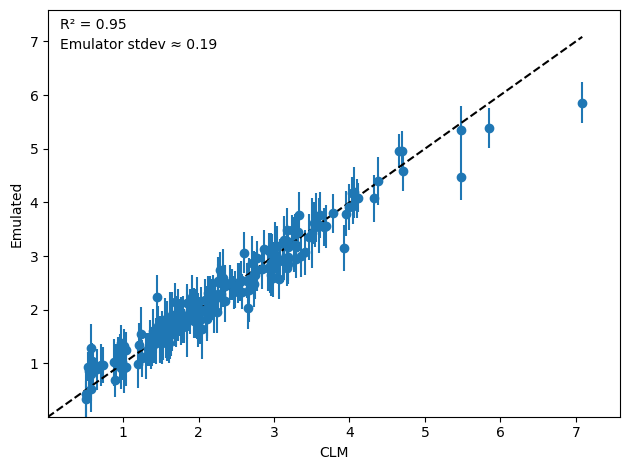

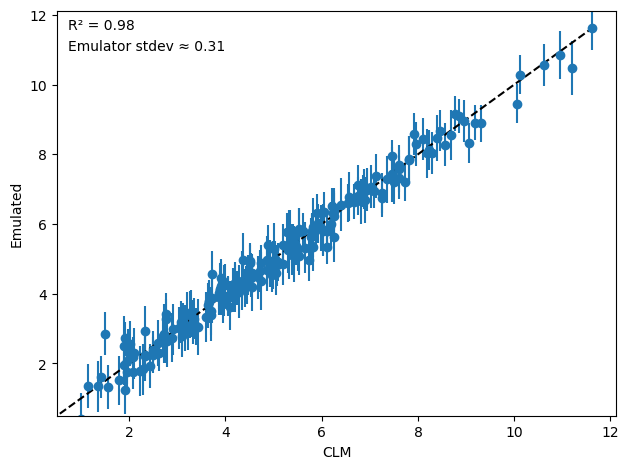

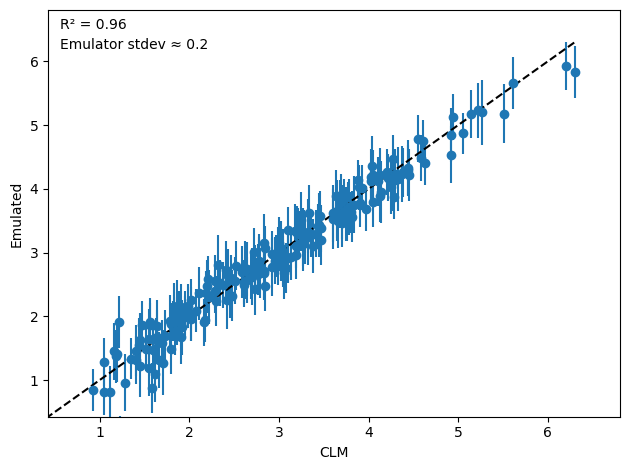

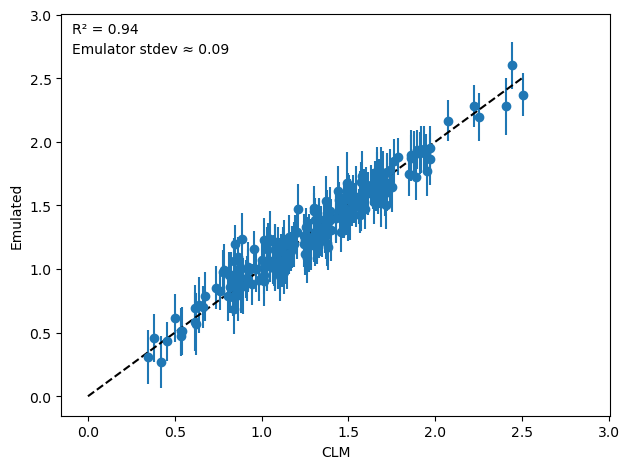

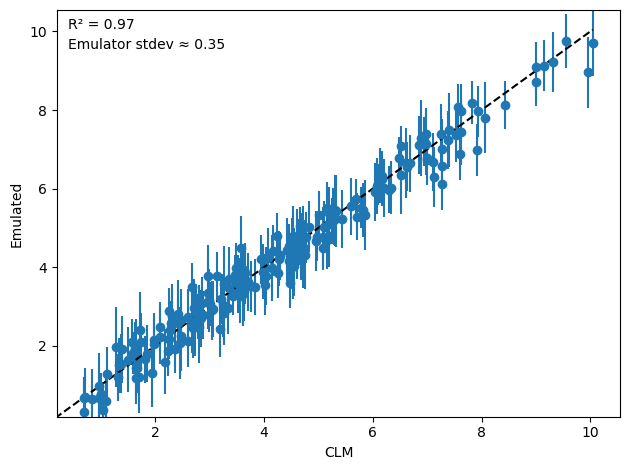

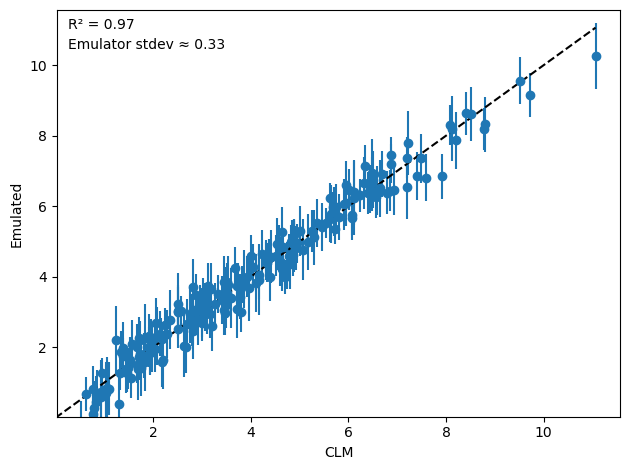

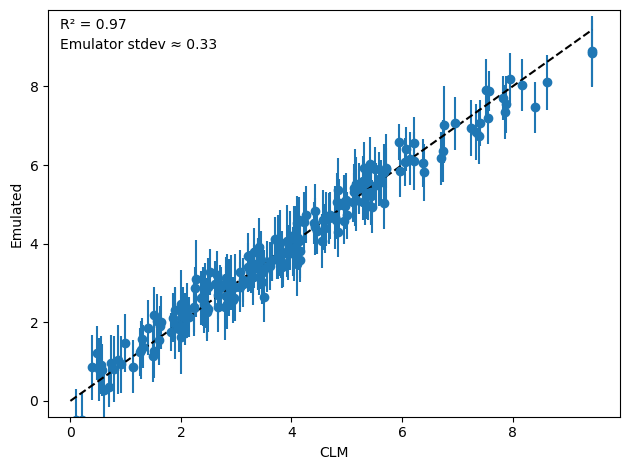

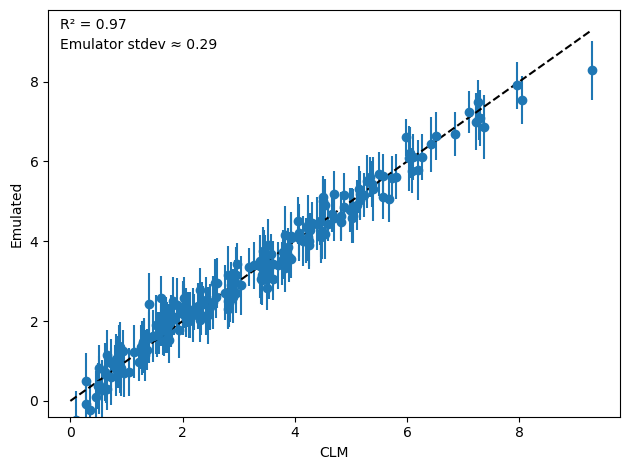

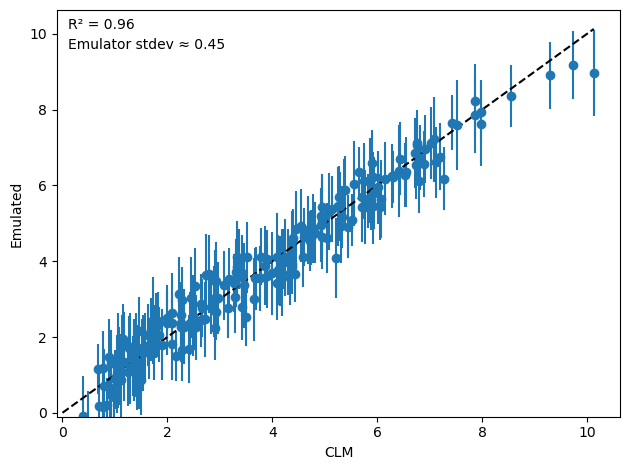

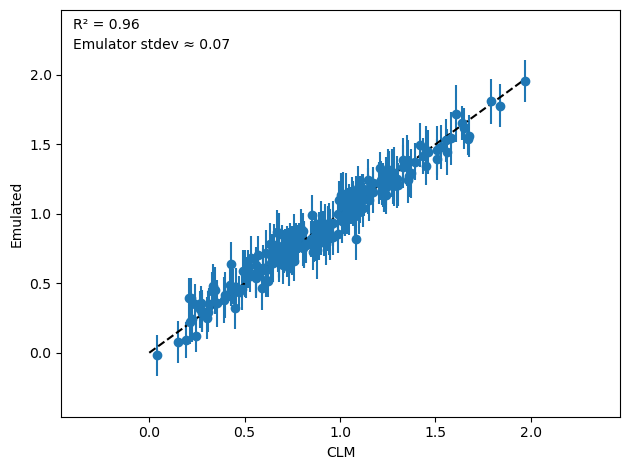

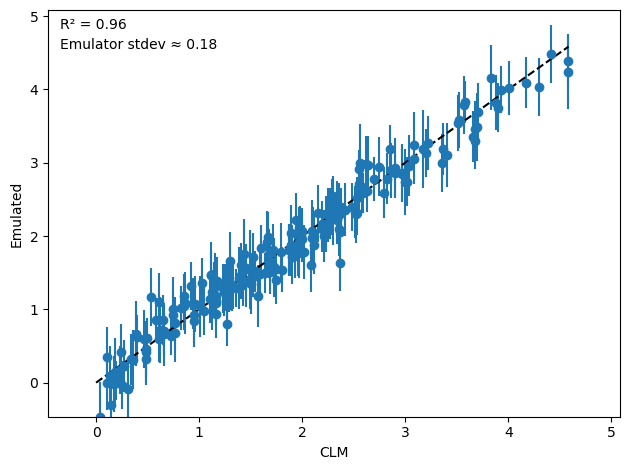

In [36]:
# Train lai emulators
for b,biome in enumerate(biome_names[1:],start=1):
    print(b,biome)
    
    X = build_X(biome,u_params,pft_params,biome_pfts)
    y_lhc = lai_lhc.sel(biome=b).mean(dim='year').values[1:]
    y_wave1 = lai_wave1.sel(biome=b).mean(dim='year').values
    Y = np.concatenate((y_lhc,y_wave1))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = 41+15*len(biome_pfts[biome])
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome+'_emulator_validation_biomelaimax.png'
    savedir = str('./emulators_biomelai/'+biome)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[6]
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

In [37]:
R2_score

array([       nan, 0.98085321, 0.9716868 , 0.95068752, 0.97881228,
       0.9598332 , 0.93911119, 0.97314482, 0.97042416, 0.97185043,
       0.9744421 , 0.96083272, 0.96111192])

### GPP

In [40]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(14)*np.NaN
stdev = np.empty(14)*np.NaN

1 Tropical rainforest
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Tropical rainforest/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Tropical rainforest/assets


2 Tropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Tropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Tropical savanna/assets


3 Subtropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Subtropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Subtropical savanna/assets


4 Broadleaf evergreen temperate tree
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Broadleaf evergreen temperate tree/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Broadleaf evergreen temperate tree/assets


5 Grasslands
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Grasslands/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Grasslands/assets


6 Shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Shrubland/assets


7 Mixed deciduous temperate forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Mixed deciduous temperate forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Mixed deciduous temperate forest/assets


8 Conifer forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Conifer forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Conifer forest/assets


9 Siberian larch
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Siberian larch/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Siberian larch/assets


10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Boreal forest/assets


11 Broadleaf deciduous boreal trees
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Broadleaf deciduous boreal trees/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Broadleaf deciduous boreal trees/assets


12 Boreal shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Boreal shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Boreal shrubland/assets


13 Tundra
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp/Tundra/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp/Tundra/assets


IndexError: index 13 is out of bounds for axis 0 with size 13

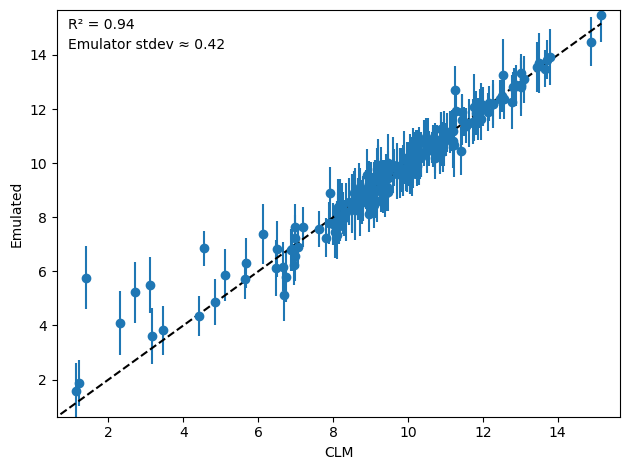

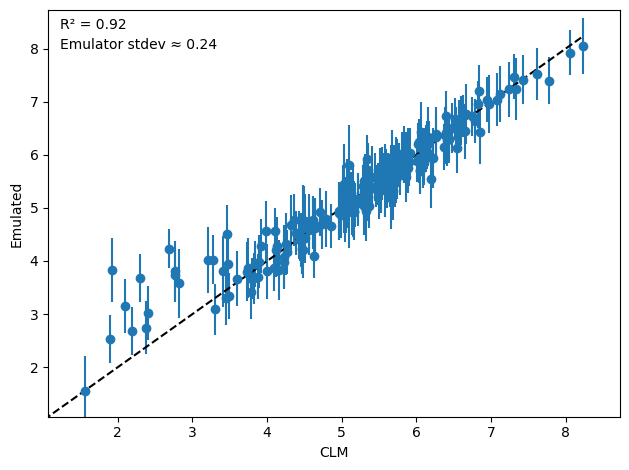

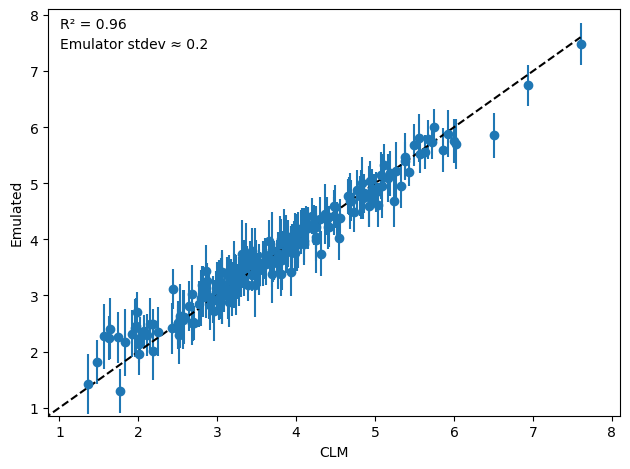

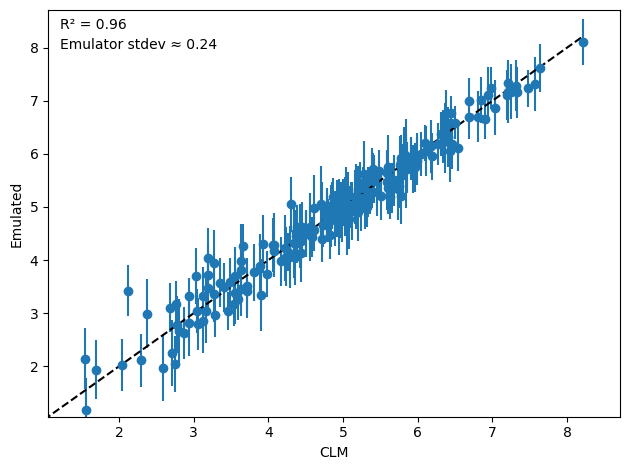

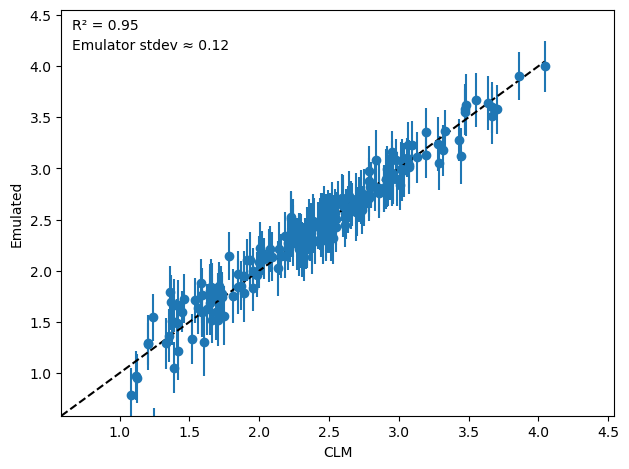

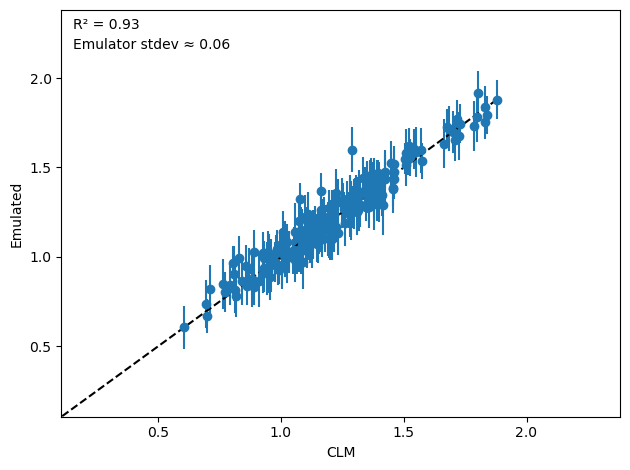

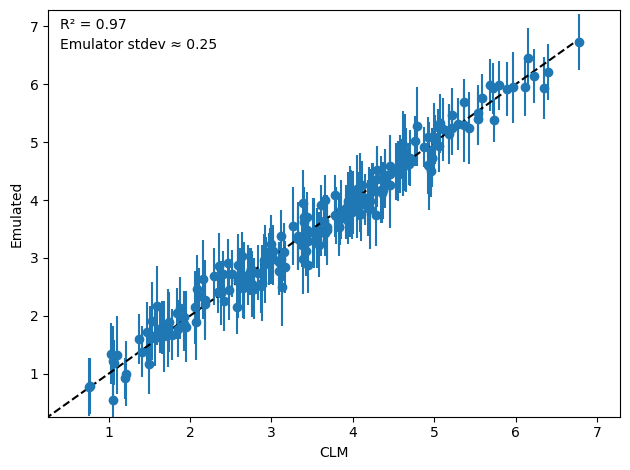

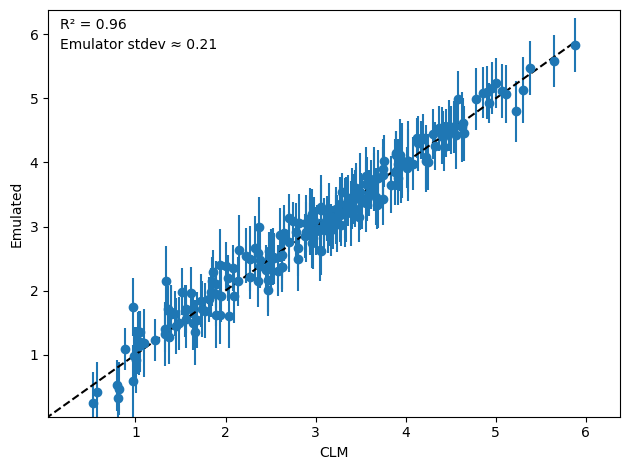

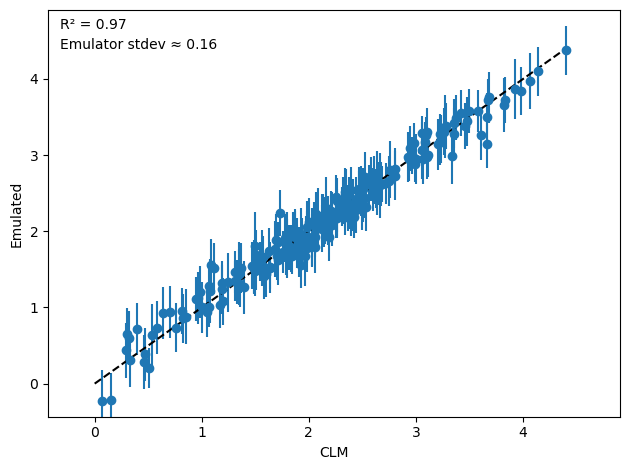

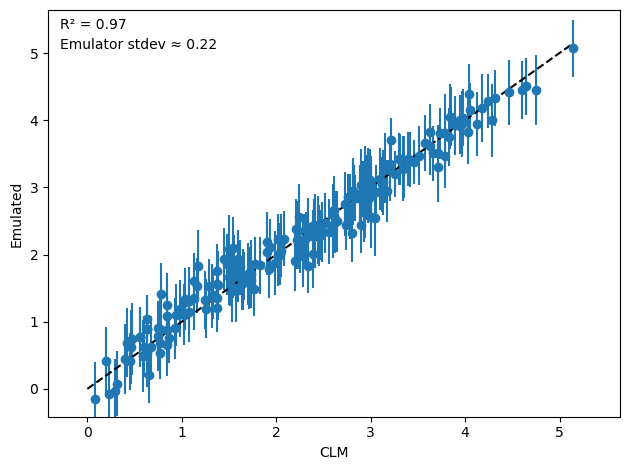

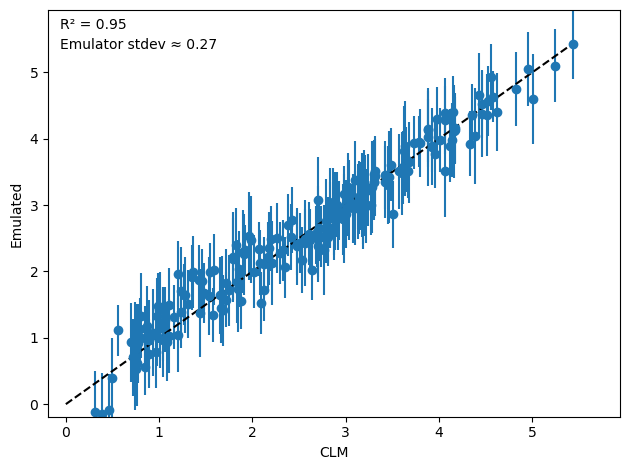

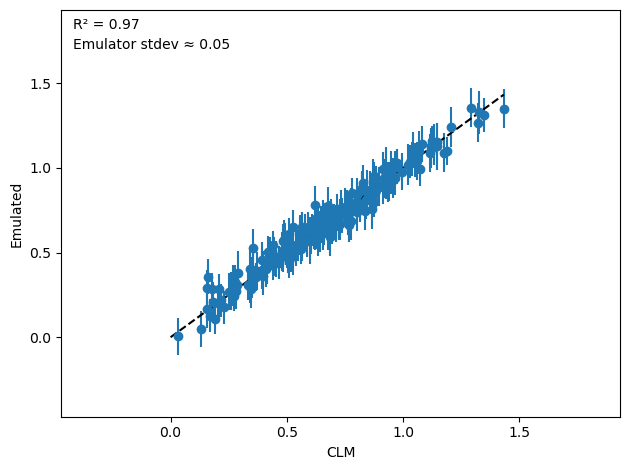

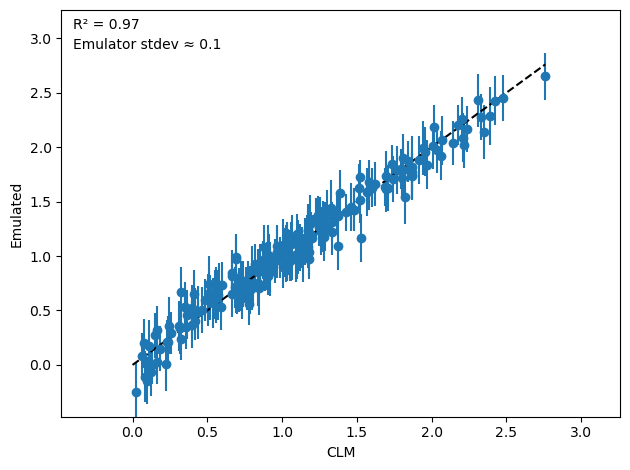

In [41]:
# Train gpp emulators (gC/m2/day)
for b,biome in enumerate(biome_names[1:],start=1):
    print(b,biome)
    
    X = build_X(biome,u_params,pft_params,biome_pfts)
    y_lhc = gpp_lhc.sel(biome=b).mean(dim='year').values[1:]
    y_wave1 = gpp_wave1.sel(biome=b).mean(dim='year').values
    Y = np.concatenate((y_lhc,y_wave1))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = 41+15*len(biome_pfts[biome])
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome+'_emulator_validation_biomegpp.png'
    savedir = str('./emulators_biomegpp/'+biome)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

In [42]:
R2_score

array([       nan, 0.94241884, 0.92326388, 0.956404  , 0.95782077,
       0.9474253 , 0.92842867, 0.97050016, 0.96472977, 0.97212299,
       0.96506194, 0.95381555, 0.96675231])

### Biomass

In [17]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(14)*np.NaN
stdev = np.empty(14)*np.NaN

9 Siberian larch
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Siberian larch/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Siberian larch/assets


10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Boreal forest/assets


11 Broadleaf deciduous boreal trees
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Broadleaf deciduous boreal trees/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Broadleaf deciduous boreal trees/assets


12 Boreal shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Boreal shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Boreal shrubland/assets


13 Tundra
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Tundra/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass/Tundra/assets


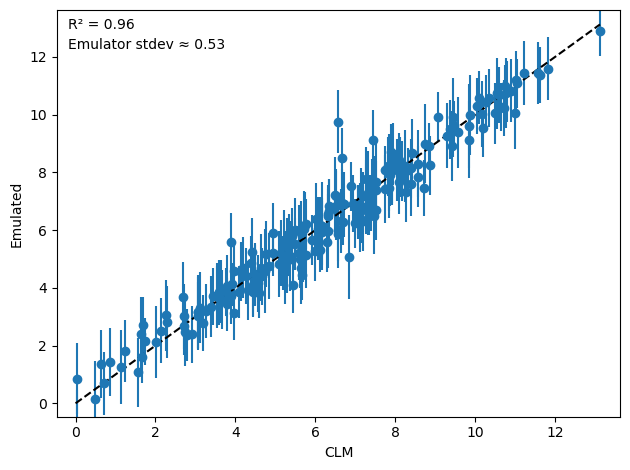

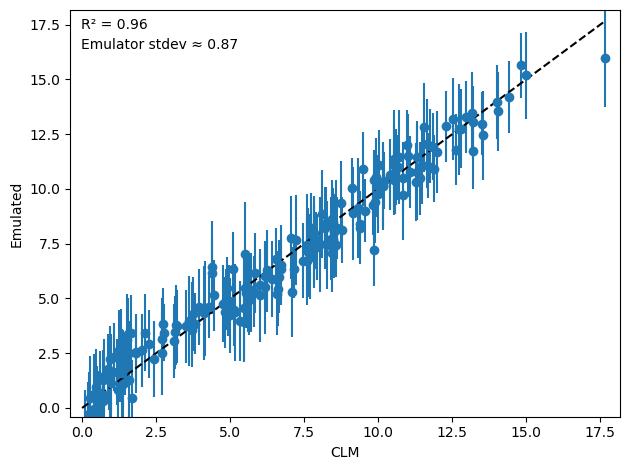

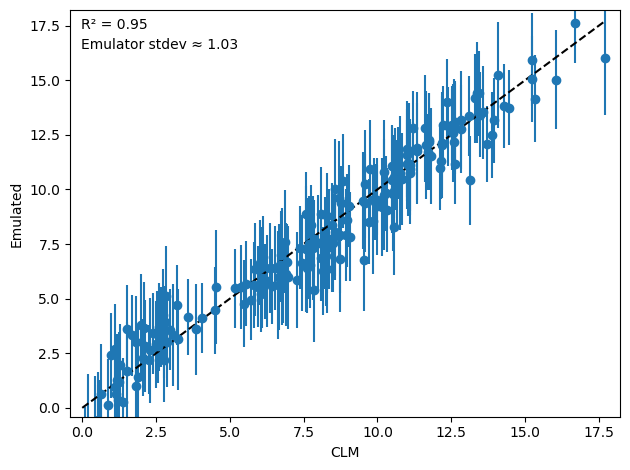

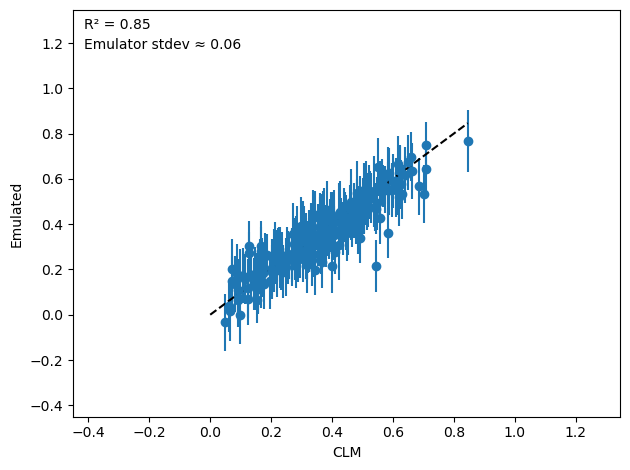

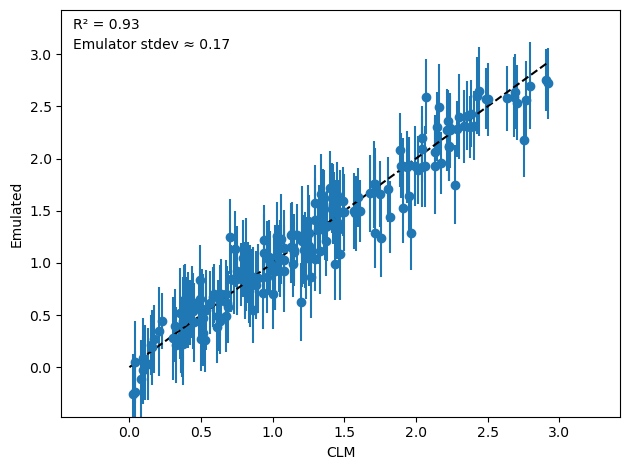

In [19]:
# Train biomass emulators (kgC/m2)
for b,biome in enumerate(biome_names[9:],start=9):
    print(b,biome)
    
    X = build_X(biome,u_params,pft_params,biome_pfts)
    y_lhc = biomass_lhc.sel(biome=b).mean(dim='year').values[1:]
    y_wave1 = biomass_wave1.sel(biome=b).mean(dim='year').values
    Y = np.concatenate((y_lhc,y_wave1))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = 41+15*len(biome_pfts[biome])
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome+'_emulator_validation_biomebiomass.png'
    savedir = str('./emulators_biomebiomass/'+biome)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

### Evapotranspiration

In [42]:
ntest = 200
X = build_X('Tundra',u_params,pft_params,biome_pfts)
ix_test = np.random.choice(np.arange(len(X)), size=ntest, replace=False)
ix_train = np.where(~np.isin(np.arange(len(X)), ix_test))[0]

In [43]:
### Load lhc

dir='/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/'
ds = xr.open_dataset(dir+'ctsm6lhc_bmean_sudoku_1850-2023.nc')
ds_lhc = ds.where(ds['crashed'] != 1, drop=True)
le_lhc = ds_lhc.EFLX_LH_TOT_biome_amean.sel(year=slice(2000,2015)).mean(dim='year').compute()

key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')
ix = np.where(ds.crashed==1)[0]
params_lhc = params.drop(ix-1)

In [44]:
######################################################
# load wave 1 data
filename = '../wave1/params/wave1_psets_021725.nc'
w1_params = xr.open_dataset(filename)

dir='/glade/work/linnia/CLM6-PPE/ctsm6_wave1/postp/'
ds = xr.open_dataset(dir+'ctsm6wave1_bmean_sudoku_1850-2023.nc')

# drop crashers
ds_wave1 = ds.where(ds['crashed'] != 1, drop=True)

ix = np.where(ds.crashed==1)[0]
params_wave1 = w1_params['values'].drop_sel(ens=ix)
params_wave1 = params_wave1.transpose("ens", "param", "pft")
params_wave1 = params_wave1.sel(param=params_lhc.columns)

le_wave1 = ds_wave1.EFLX_LH_TOT_biome_amean.sel(year=slice(2000,2015)).mean(dim='year').compute()

In [45]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(14)*np.NaN
stdev = np.empty(14)*np.NaN

1 Tropical rainforest
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Tropical rainforest/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Tropical rainforest/assets


2 Tropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Tropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Tropical savanna/assets


3 Subtropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Subtropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Subtropical savanna/assets


4 Broadleaf evergreen temperate tree
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Broadleaf evergreen temperate tree/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Broadleaf evergreen temperate tree/assets


5 Grasslands
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Grasslands/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Grasslands/assets


6 Shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Shrubland/assets


7 Mixed deciduous temperate forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Mixed deciduous temperate forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Mixed deciduous temperate forest/assets


8 Conifer forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Conifer forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Conifer forest/assets


9 Siberian larch
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Siberian larch/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Siberian larch/assets


10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Boreal forest/assets


11 Broadleaf deciduous boreal trees
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Broadleaf deciduous boreal trees/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Broadleaf deciduous boreal trees/assets


12 Boreal shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Boreal shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Boreal shrubland/assets


13 Tundra
saving
INFO:tensorflow:Assets written to: ./emulators_biomele/Tundra/assets


INFO:tensorflow:Assets written to: ./emulators_biomele/Tundra/assets


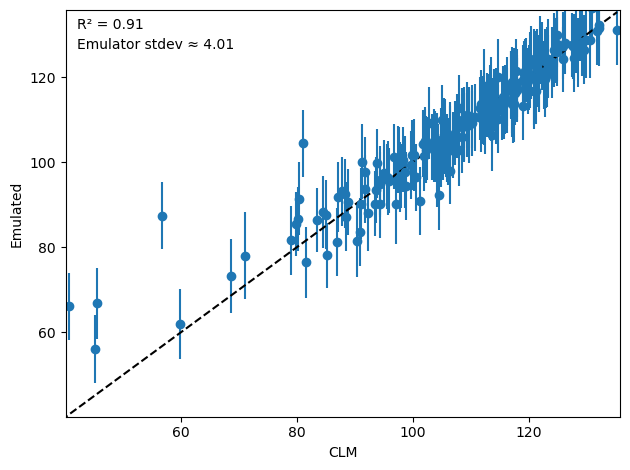

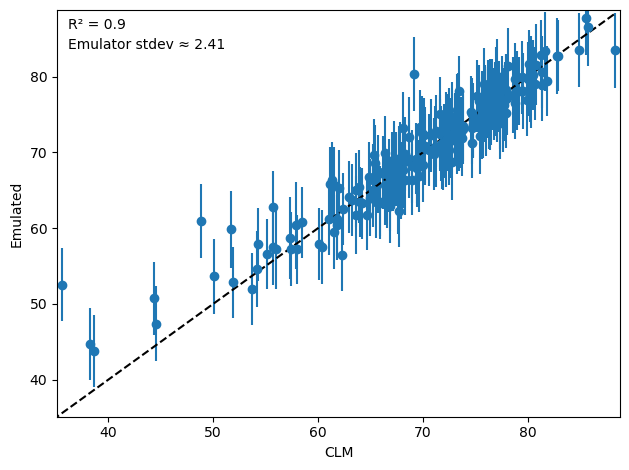

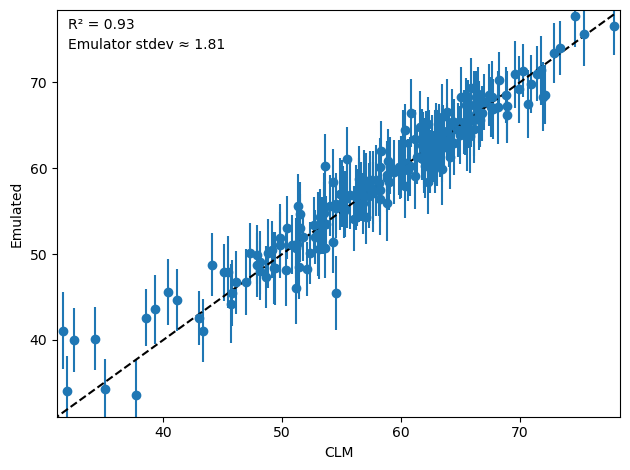

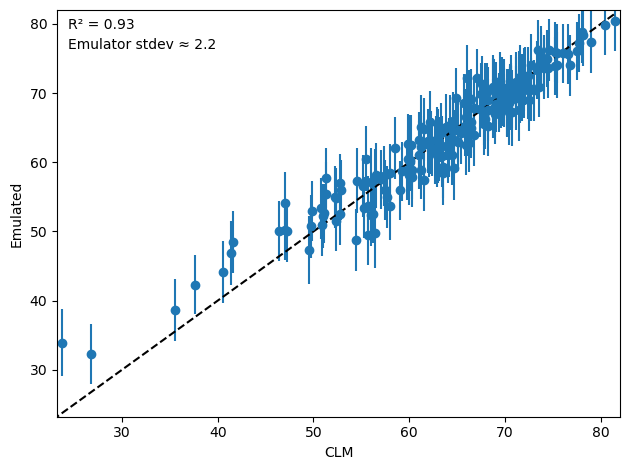

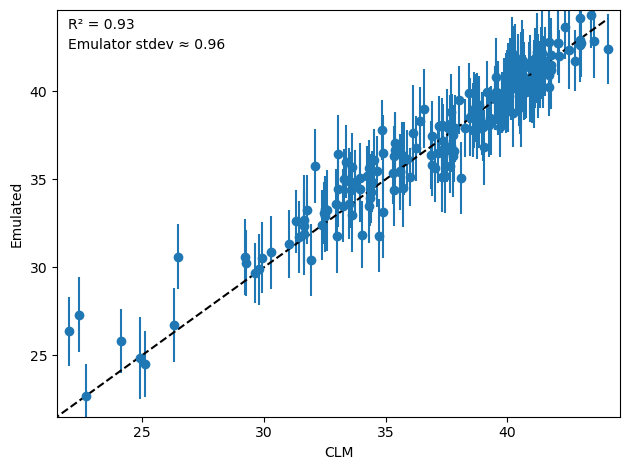

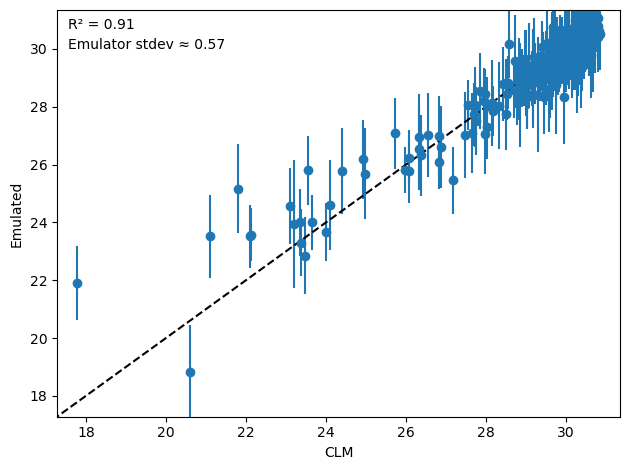

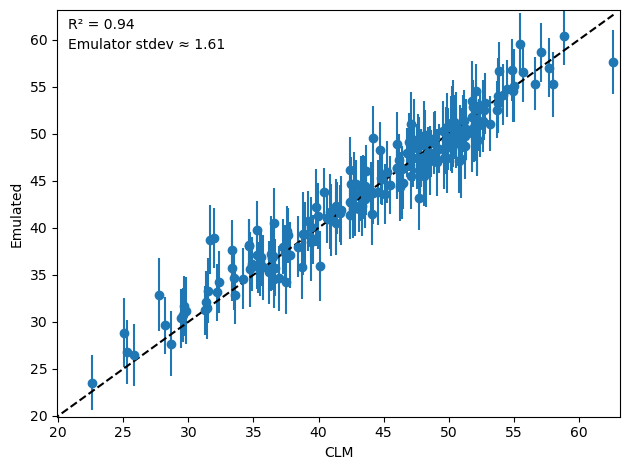

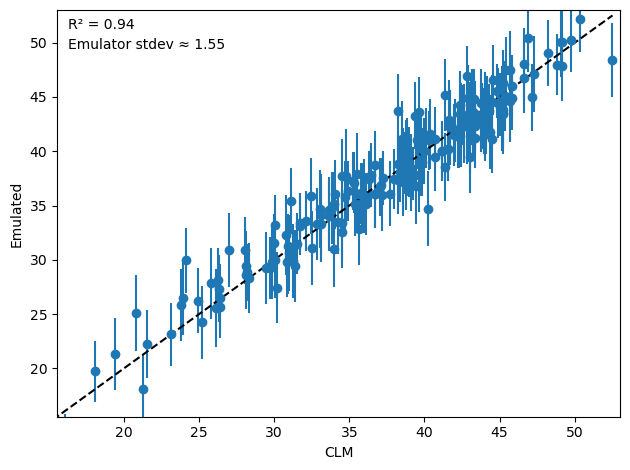

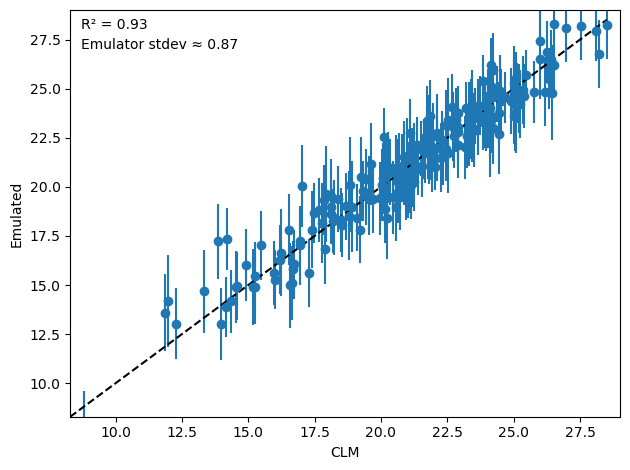

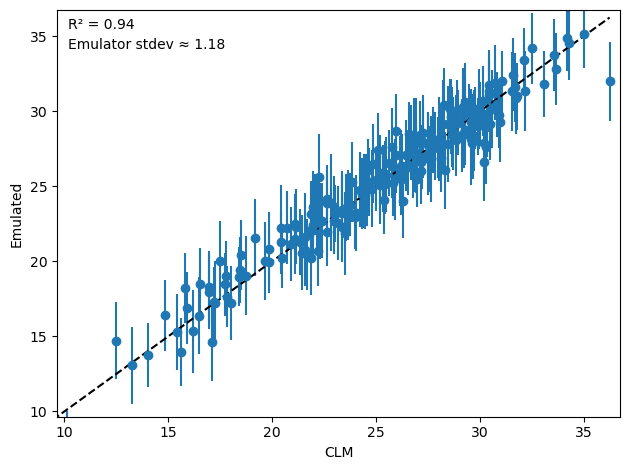

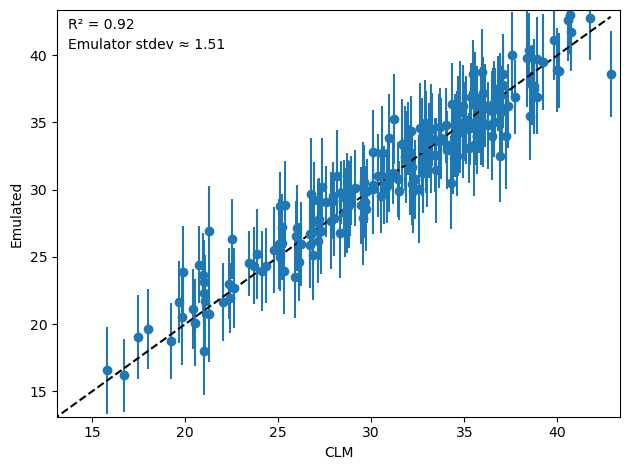

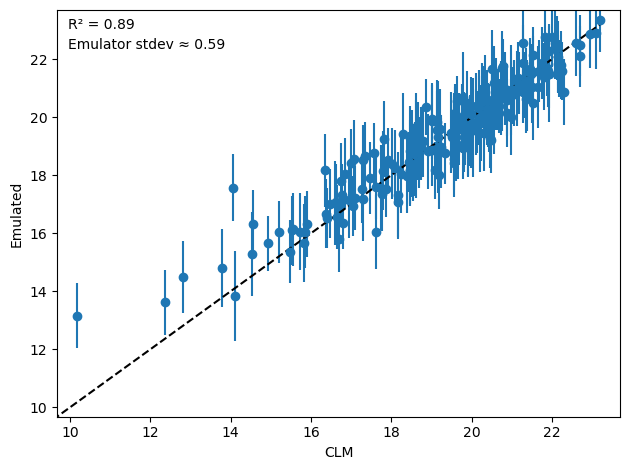

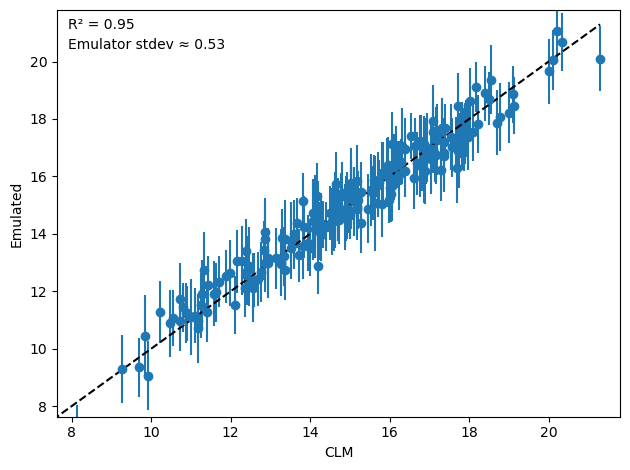

In [54]:
# Train le emulators (W/m2)
for b,biome in enumerate(biome_names[1:],start=1):
    print(b,biome)
    
    X = build_X(biome,u_params,pft_params,biome_pfts)
    y_lhc = le_lhc.sel(biome=b).values[1:]
    y_wave1 = le_wave1.sel(biome=b).values
    Y = np.concatenate((y_lhc,y_wave1))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = 41+15*len(biome_pfts[biome])
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome+'_emulator_validation_biomele.png'
    savedir = str('./emulators_biomele/'+biome)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

In [55]:
R2_score

array([       nan, 0.90783313, 0.90167489, 0.93074682, 0.92520573,
       0.92512386, 0.90811935, 0.94196808, 0.93895348, 0.92998847,
       0.94463708, 0.92313298, 0.89395157, 0.95291521])

### Plot R2_score

In [52]:
R2_all = [[0.98085321, 0.9716868 , 0.95068752, 0.97881228,0.9598332 , 0.93911119, 0.97314482, 0.97042416, 0.97185043,0.9744421 , 0.96083272, 0.96111192, 0.96],
          [0.94241884, 0.92326388, 0.956404  , 0.95782077,0.9474253 , 0.92842867, 0.97050016, 0.96472977, 0.97212299,0.96506194, 0.95381555, 0.96675231, 0.97],
          [0.96,0.97,0.94,0.95,0.93,0.94,0.97,0.97,0.96,0.96,0.95,0.85,0.93]]

In [53]:
row_names = ['LAI', 'GPP', 'Biomass']
df = pd.DataFrame(R2_all,columns=biome_names[1:],index=row_names)

In [54]:
import seaborn as sns

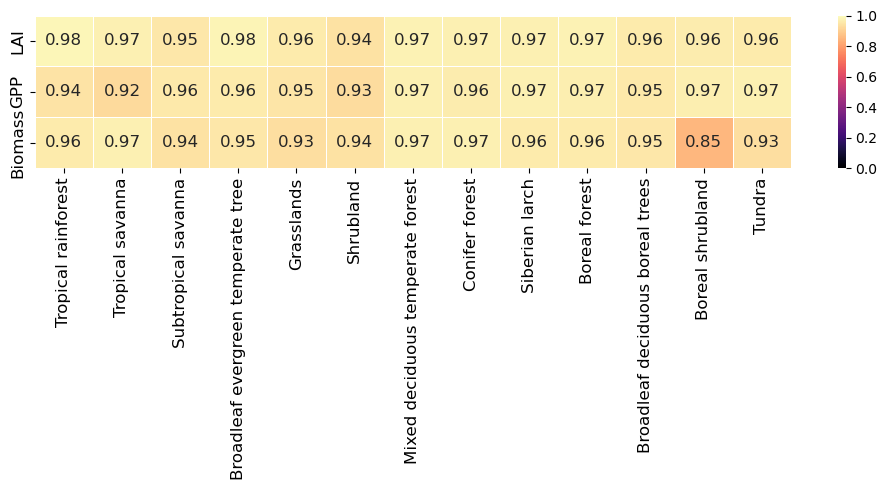

In [55]:

plt.figure(figsize=(10, 5))
ax = sns.heatmap(df, annot=True, cmap='magma', vmin=0, vmax=1, fmt=".2f", linewidths=0.5,
                 annot_kws={"size": 12})  # Adjust annotation font size
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('emulator_evaluation_heatmap.png',dpi=200)